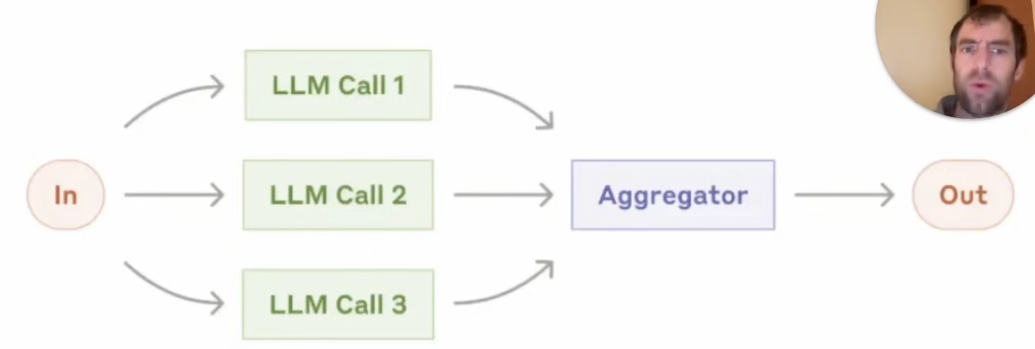

In [14]:
"""
在查询的时候（包括web搜索，RAG搜索，以及外部数据搜索等等），需要并行化处理。
并行搜索的优势：
1. 提高搜索效率
2. 减少搜索延迟
"""
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from IPython.display import Image,display
import os

llm = ChatOpenAI(
    model_name="qwen-turbo-latest",
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)

class State(TypedDict):
    topic:str
    joke:str
    story:str
    poem:str
    combined_output:str

In [15]:
# Nodes
def call_llm_1(state:State):
    """First LLM call to generate initial joke"""
    return {"joke":llm.invoke(f"write a short joke about {state['topic']}").content}

def call_llm_2(state:State):
    """Second LLM to generate story"""
    return {"story":llm.invoke(f"write a short story about {state['topic']}").content}

def call_llm_3(state:State):
    """Third LLM to generate poem"""
    return {"poem":llm.invoke(f"write a short poem about {state['topic']}").content}

def aggregator(state:State):
    combined = f"""Here's a story,joke and poem about {state['topic']} !\n\n
    STORY:\n{state['story']}\n\n
    JOKE:\n{state['joke']}\n\n
    POEM:\n{state['poem']}
    """
    return {"combined_output":combined}

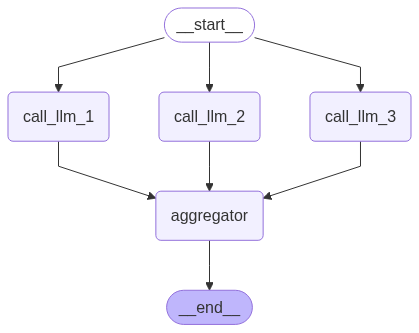

In [16]:
# build workflow
parallel_builder = StateGraph(State)
# add nodes
parallel_builder.add_node("call_llm_1",call_llm_1)
parallel_builder.add_node("call_llm_2",call_llm_2)
parallel_builder.add_node("call_llm_3",call_llm_3)
parallel_builder.add_node("aggregator",aggregator)
# add entry point
parallel_builder.add_edge(START,"call_llm_1")
parallel_builder.add_edge(START,"call_llm_2")
parallel_builder.add_edge(START,"call_llm_3")
# add edges
parallel_builder.add_edge("call_llm_1","aggregator")
parallel_builder.add_edge("call_llm_2","aggregator")
parallel_builder.add_edge("call_llm_3","aggregator")
# add exit point
parallel_builder.add_edge("aggregator",END)
# build graph
parallel_agent = parallel_builder.compile()
display(Image(parallel_agent.get_graph().draw_mermaid_png()))

In [17]:
state = parallel_agent.invoke({"topic":"cat"})
for k,v in state.items():
    print(k,'->',v)

topic ->  cat
joke ->  Why don't cats like fast food?  
Because they prefer their meals *purr*-fected! 🐾😄
story ->  The rain lashed against the windowpane, turning the world outside into a watercolor blur. Inside, Mr. Pawsington, a ginger tabby with fur like sun-dappled leaves, sat perched on the windowsill, tail twitching with restless energy. He wasn't bored, exactly. He was *waiting*.

His human, Elara, was asleep in the next room, her breathing a soft rhythm that usually soothed him. But tonight, something else stirred in the quiet house. A faint, rhythmic *thump-thump-thump* vibrated through the floorboards, barely audible beneath the drumming rain. It wasn't the furnace. It wasn't the fridge. It was... different. Like a tiny heart beating just for him.

Mr. Pawsington’s ears swiveled, catching the subtle shift in the sound. It pulsed again, stronger this time, emanating from the old, dusty bookshelf tucked in the corner of the living room. He hopped down, landing silently on paws